In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import stats
import json

import os,sys
sys.path.append(os.path.abspath('../../Software/rate_analysis/'))
import rate_methods as RM

## Figure 5: 2-CV Biasing for Protein G

In [2]:
trajE = np.loadtxt('../../Data/unbiased_cvs.colvar',usecols=2,skiprows=1)
trajG = np.loadtxt('../../Data/unbiased_cvs.colvar',usecols=4,skiprows=1)

In [3]:
traj = np.vstack((trajG[::20],trajE[::20]))

X, Y = np.mgrid[1:3.5:500j, 0:10:500j]
positions = np.vstack((X.ravel(),Y.ravel()))
kernel = stats.gaussian_kde(traj)

Z = np.reshape(kernel(positions).T, X.shape)

kT = 0.008314*312/4.184

A = -kT*np.log(Z)
A -= np.min(A)
A = np.clip(A,0,8)

In [4]:
with open('../Rates/rates_GE_wt.json','r') as f:
    GE_rates_data = json.load(f)

true = 1.4328652141523972
pace = [100,1000,1e4,2e4,5e4,1e5,5e5,1e6]

In [5]:
def get_EATR_CDF(k0, gamma, beta, directory, colvar_name, log_name, plog_len, biascol, t=None):
    print(f"{directory}")
    colvars = []
    plogs = []
    runs = [f"run_{i+1}" for i in range(100)]
    for run in runs:
        colvars.append(f"{directory}/{run}/{colvar_name}")
        plogs.append(f"{directory}/{run}/{log_name}")
        
    colvars_count = len(colvars)
    colvars_maxrow_count = None
    
    data = []
    times = []
    for colvar in colvars:
        data.append(np.loadtxt(colvar))
        times.append(data[-1][-1][0])
        colvars_maxrow_count = data[-1].shape[0] if colvars_maxrow_count is None or colvars_maxrow_count < data[-1].shape[0] else colvars_maxrow_count
    
    event = []
    for plog in plogs:
        with open(plog,'r') as f:
            if len(f.readlines()) > plog_len:
                event.append(True)
            else:
                event.append(False)
    event = np.array(event)
    M = event.sum()
    
    times = np.sort(times)
    v_data, ix_col = RM.inst_bias(data, colvars_count, colvars_maxrow_count, beta, biascol)
    spline = RM.EATR_calculate_avg_acc(gamma, v_data, beta, ix_col)
    if t is not None:
        return times, RM.EATR_CDF(t, k0, gamma, spline, 1), M
    return times, RM.EATR_CDF(times, k0, gamma, spline, 1), M

def just_times(directory, colvar_name, log_name, plog_len):
    
    colvars = []
    plogs = []
    runs = [f"run_{i+1}" for i in range(100)]
    for run in runs:
        colvars.append(f"{directory}/{run}/{colvar_name}")
        plogs.append(f"{directory}/{run}/{log_name}")
    
    times = []
    for colvar in colvars:
        times.append(np.loadtxt(colvar)[-1][0])
    times = np.array(times)
        
    event = []
    for plog in plogs:
        with open(plog,'r') as f:
            if len(f.readlines()) > plog_len:
                event.append(True)
            else:
                event.append(False)
    event = np.array(event)
        
    return np.sort(times[event]), event.sum()

In [6]:
headdir = "../../Data/2D_GE_wt/"
directories = ['geruns_pace1e2','geruns_pace1e3','geruns_pace1e4','geruns_pace2e4','geruns_pace5e4','geruns_pace1e5','geruns_pace5e5','geruns_pace1e6']

ecdfxs = []
ecdfys = []
tcdfxs = []
tcdfys = []

for i, directory in enumerate(directories):
    ts, M = just_times(headdir+directory,"metad.colvar","p.log",159)
    ecdfxs.append(ts)
    ecdfys.append(np.arange(1, M+1) / 100.)
    tcdfxs.append(10**np.linspace( np.log10(ts[0])-0.3, np.log10(ts[-1])+0.3, 500 ))
    tcdfys.append(get_EATR_CDF(GE_rates_data["EATR CDF k"][i], GE_rates_data["EATR CDF g"][i], 0.3855097673, headdir+directory, "metad.colvar", "p.log", 159, 3, t=tcdfxs[-1])[1])

../../Data/2D_GE_wt/geruns_pace1e2
../../Data/2D_GE_wt/geruns_pace1e3
../../Data/2D_GE_wt/geruns_pace1e4
../../Data/2D_GE_wt/geruns_pace2e4
../../Data/2D_GE_wt/geruns_pace5e4
../../Data/2D_GE_wt/geruns_pace1e5
../../Data/2D_GE_wt/geruns_pace5e5
../../Data/2D_GE_wt/geruns_pace1e6


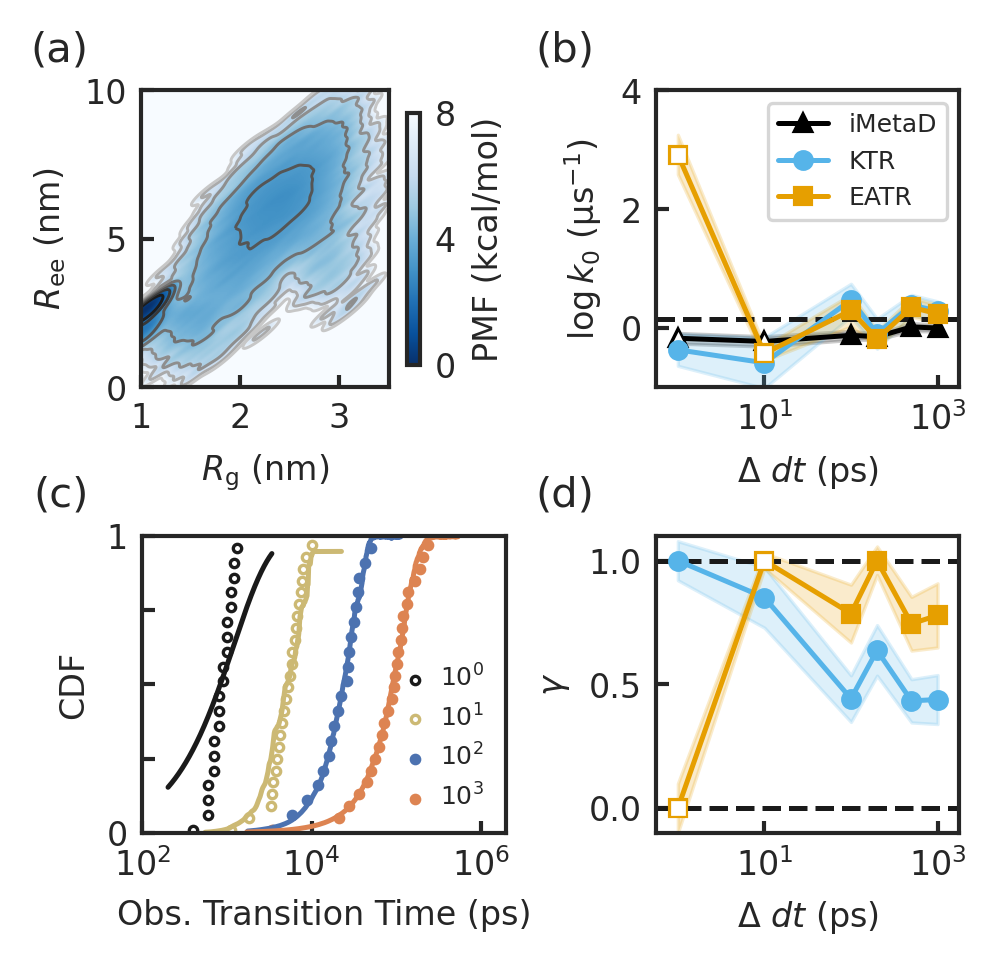

In [7]:
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper', rc={'axes.labelsize': 8, 'axes.linewidth': 1.0, 'lines.linewidth': 1.2, 'axes.titlesize': 12,
                             'xtick.labelsize': 8, 'ytick.labelsize': 8, 'xtick.major.width': 1.0, 'ytick.major.width': 1.0,
                             'legend.fontsize': 6, 'legend.framealpha': 0, 'lines.markersize': 4})

fig, axes = plt.subplots(2,2, figsize=(3.3,3.3), dpi=300, edgecolor='k', gridspec_kw={"width_ratios" : [1.2,1]})
fig.subplots_adjust(wspace=0.45,hspace=0.5, bottom=0.15, top=0.90, right=0.95)

failedIMD = [0,1,6,7]
failedIMD_2 = [0,1]
failedKTR = [6,7]
failedKTR_2 = []
failedEATR = [0,1,6,7]
failedEATR_2 = [0,1]

pmf = axes[0,0].imshow(np.rot90(A),extent=[1, 3.5, 0, 10],cmap='Blues_r',aspect=3./10.)
axes[0,0].contour(X,Y,A,cmap='binary_r',linewidths=0.7,levels=np.linspace(0,10,10))
axes[0,0].set_xlim([1, 3.5])
axes[0,0].set_xlabel('$R_\mathrm{g}$ (nm)')
axes[0,0].set_xticks([1,2,3])
axes[0,0].set_yticks([0,5,10])
axes[0,0].set_ylim([0, 10])
axes[0,0].set_ylabel('$R_\mathrm{ee}$ (nm)')
cbar = fig.colorbar(pmf,shrink=0.85)
cbar.set_label('PMF (kcal/mol)')
cbar.ax.set_yticks([0,4,8])
cbar.ax.tick_params(length=0)
axes[0,0].tick_params(axis='both', direction='in', which='both', length=3)
axes[0,0].text(-0.45,1.1,"(a)",fontsize=10,transform=axes[0,0].transAxes)
pos = axes[0,0].get_position()
pos.x0 = pos.x0 - 0.045
pos.x1 = pos.x1 - 0.045
axes[0,0].set_position(pos)
pos = cbar.ax.get_position()
pos.x0 = pos.x0 - 0.045
pos.x1 = pos.x1 - 0.045
cbar.ax.set_position(pos)

axes[0,1].axhline(y=np.log10(true),color='k',linestyle='--')
axes[0,1].fill_between(np.array(pace)[:6]/100,np.log10(np.array(GE_rates_data["iMetaD CDF k"])[:6]*1e6)-GE_rates_data["iMetaD CDF std k"][:6],np.log10(np.array(GE_rates_data["iMetaD CDF k"])[:6]*1e6)+GE_rates_data["iMetaD CDF std k"][:6],color='#000000',alpha=0.2)
axes[0,1].plot(np.array(pace)[:6]/100,np.log10(np.array(GE_rates_data["iMetaD CDF k"])[:6]*1e6),marker='^',label='iMetaD',color='#000000')
axes[0,1].plot(np.array(pace)[failedIMD_2]/100,np.log10(np.array(GE_rates_data["iMetaD CDF k"])[failedIMD_2]*1e6),marker='^',mfc='#FFFFFF',mew=0.3,color='#000000',linestyle='')
axes[0,1].fill_between(np.array(pace)[:6]/100,np.log10(np.array(GE_rates_data["KTR Vmb CDF k"])[:6]*1e6)-GE_rates_data["KTR Vmb CDF std k"][:6],np.log10(np.array(GE_rates_data["KTR Vmb CDF k"])[:6]*1e6)+GE_rates_data["KTR Vmb CDF std k"][:6],color='#56B4E9',alpha=0.2)
axes[0,1].plot(np.array(pace)[:6]/100,np.log10(np.array(GE_rates_data["KTR Vmb CDF k"])[:6]*1e6),marker='o',label='KTR',color='#56B4E9')
axes[0,1].plot(np.array(pace)[failedKTR_2]/100,np.log10(np.array(GE_rates_data["KTR Vmb CDF k"])[failedKTR_2]*1e6),marker='o',mfc='#FFFFFF',mew=0.3,color='#56B4E9',linestyle='')
axes[0,1].fill_between(np.array(pace)[:6]/100,np.log10(np.array(GE_rates_data["EATR CDF k"])[:6]*1e6)-GE_rates_data["EATR CDF std k"][:6],np.log10(np.array(GE_rates_data["EATR CDF k"])[:6]*1e6)+GE_rates_data["EATR CDF std k"][:6],color='#E69F00',alpha=0.2)
axes[0,1].plot(np.array(pace)[:6]/100,np.log10(np.array(GE_rates_data["EATR CDF k"])[:6]*1e6),marker='s',label='EATR',color='#E69F00')
axes[0,1].plot(np.array(pace)[failedEATR_2]/100,np.log10(np.array(GE_rates_data["EATR CDF k"])[failedEATR_2]*1e6),marker='s',mfc='#FFFFFF',mew=0.3,color='#E69F00',linestyle='')
axes[0,1].set_xlabel('$\Delta~dt$ (ps)')
axes[0,1].set_ylabel('$\log k_0$ ($\mathrm{\mu s}^{-1}$)')
axes[0,1].set_xscale('log')
axes[0,1].set_xlim((5.62e-1,1.78e3))
axes[0,1].set_ylim((-1,4))
axes[0,1].tick_params(axis='both', direction='in', which='both', length=3)
axes[0,1].legend()
axes[0,1].text(-0.4,1.1,"(b)",fontsize=10,transform=axes[0,1].transAxes)

axes[1,1].axhline(y=0,color='k',linestyle='--')
axes[1,1].axhline(y=1,color='k',linestyle='--')
axes[1,1].fill_between(np.array(pace)[:6]/100,np.array(GE_rates_data["KTR Vmb CDF g"])[:6]-GE_rates_data["KTR Vmb CDF std g"][:6],np.array(GE_rates_data["KTR Vmb CDF g"])[:6]+GE_rates_data["KTR Vmb CDF std g"][:6],color='#56B4E9',alpha=0.2)
axes[1,1].plot(np.array(pace)[:6]/100,np.array(GE_rates_data["KTR Vmb CDF g"])[:6],marker='o',label='KTR',color='#56B4E9')
axes[1,1].plot(np.array(pace)[failedKTR_2]/100,np.array(GE_rates_data["KTR Vmb CDF g"])[failedKTR_2],marker='o',mfc='#FFFFFF',mew=0.3,color='#56B4E9',linestyle='')
axes[1,1].fill_between(np.array(pace)[:6]/100,np.array(GE_rates_data["EATR CDF g"])[:6]-GE_rates_data["EATR CDF std g"][:6],np.array(GE_rates_data["EATR CDF g"])[:6]+GE_rates_data["EATR CDF std g"][:6],color='#E69F00',alpha=0.2)
axes[1,1].plot(np.array(pace)[:6]/100,np.array(GE_rates_data["EATR CDF g"])[:6],marker='s',label='EATR',color='#E69F00')
axes[1,1].plot(np.array(pace)[failedEATR_2]/100,np.array(GE_rates_data["EATR CDF g"])[failedEATR_2],marker='s',mfc='#FFFFFF',mew=0.3,color='#E69F00',linestyle='')
axes[1,1].set_xlabel('$\Delta~dt$ (ps)')
axes[1,1].set_ylabel('$\gamma$')
axes[1,1].set_xscale('log')
axes[1,1].set_xlim((5.62e-1,1.78e3))
axes[1,1].set_ylim((-0.1,1.1))
axes[1,1].set_yticks([0,0.5,1])
axes[1,1].tick_params(axis='both', direction='in', which='both', length=3)
axes[1,1].text(-0.4,1.1,"(d)",fontsize=10,transform=axes[1,1].transAxes)

axes[1,0].set_xlabel('Obs. Transition Time (ps)')
axes[1,0].set_ylabel('CDF')
axes[1,0].set_xlim((1e2,2e6))
axes[1,0].set_ylim((0,1))
axes[1,0].set_xscale('log')
colors=['k',"#F0E442",'#56B4E9','#009E75','#E69F00']
axes[1,0].plot(tcdfxs[0],tcdfys[0],linestyle='-',color='k')
axes[1,0].scatter(ecdfxs[0][::5],ecdfys[0][::5],marker='.',color='#FFFFFF',edgecolors='k',label='$10^0$')
axes[1,0].plot(tcdfxs[1],tcdfys[1],linestyle='-',color='y')
axes[1,0].scatter(ecdfxs[1][::4],ecdfys[1][::4],marker='.',color='#FFFFFF',edgecolors='y',label='$10^1$')
axes[1,0].plot(tcdfxs[2],tcdfys[2],linestyle='-')
axes[1,0].scatter(ecdfxs[2][::5],ecdfys[2][::5],marker='.',label='$10^2$')
axes[1,0].plot(tcdfxs[5],tcdfys[5],linestyle='-')
axes[1,0].scatter(ecdfxs[5][::4],ecdfys[5][::4],marker='.',label='$10^3$')
axes[1,0].set_yticks([0,0.25,0.5,0.75,1],labels=['0','','','','1'])
axes[1,0].tick_params(axis='both', direction='in', which='both',length=3)
axes[1,0].legend(loc="lower right",frameon=False,handletextpad=0)
axes[1,0].text(-0.3,1.1,"(c)",fontsize=10,transform=axes[1,0].transAxes)

plt.savefig("EATR_Fig5.pdf",format='pdf')
plt.show()
plt.close(fig)

## Figure S6: Incomplete Simulations from 2-CV Biasing

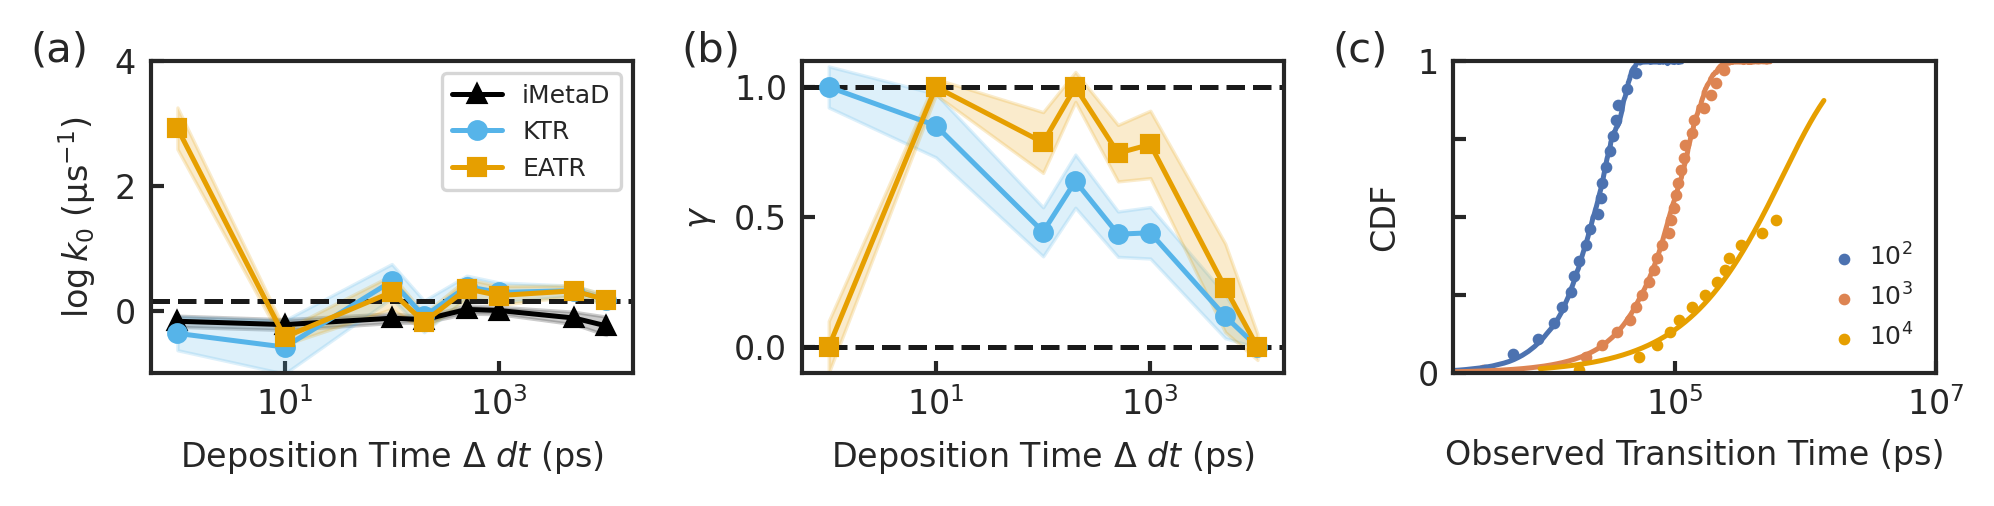

In [8]:
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper', rc={'axes.labelsize': 8, 'axes.linewidth': 1.0, 'lines.linewidth': 1.2, 'axes.titlesize': 12,
                             'xtick.labelsize': 8, 'ytick.labelsize': 8, 'xtick.major.width': 1.0, 'ytick.major.width': 1.0,
                             'legend.fontsize': 6, 'legend.framealpha': 0, 'lines.markersize': 4})

fig, axes = plt.subplots(1,3, figsize=(7.0,1.6), dpi=300)#, gridspec_kw={"width_ratios" : [1,1,1.5]})
fig.subplots_adjust(wspace=0.35, hspace=0.5, left=0.1, bottom=0.25, top=0.90, right=0.95)

axes[0].axhline(y=np.log10(true),color='k',linestyle='--')
axes[0].fill_between(np.array(pace)/100,np.log10(np.array(GE_rates_data["iMetaD CDF k"])*1e6)-GE_rates_data["iMetaD CDF std k"],np.log10(np.array(GE_rates_data["iMetaD CDF k"])*1e6)+GE_rates_data["iMetaD CDF std k"],color='#000000',alpha=0.2)
axes[0].plot(np.array(pace)/100,np.log10(np.array(GE_rates_data["iMetaD CDF k"])*1e6),marker='^',label='iMetaD',color='#000000')
axes[0].fill_between(np.array(pace)/100,np.log10(np.array(GE_rates_data["KTR Vmb CDF k"])*1e6)-GE_rates_data["KTR Vmb CDF std k"],np.log10(np.array(GE_rates_data["KTR Vmb CDF k"])*1e6)+GE_rates_data["KTR Vmb CDF std k"],color='#56B4E9',alpha=0.2)
axes[0].plot(np.array(pace)/100,np.log10(np.array(GE_rates_data["KTR Vmb CDF k"])*1e6),marker='o',label='KTR',color='#56B4E9')
axes[0].fill_between(np.array(pace)/100,np.log10(np.array(GE_rates_data["EATR CDF k"])*1e6)-GE_rates_data["EATR CDF std k"],np.log10(np.array(GE_rates_data["EATR CDF k"])*1e6)+GE_rates_data["EATR CDF std k"],color='#E69F00',alpha=0.2)
axes[0].plot(np.array(pace)/100,np.log10(np.array(GE_rates_data["EATR CDF k"])*1e6),marker='s',label='EATR',color='#E69F00')
axes[0].set_xlabel('Deposition Time $\Delta~dt$ (ps)')
axes[0].set_ylabel('$\log k_0$ ($\mathrm{\mu s}^{-1}$)')
axes[0].set_xscale('log')
axes[0].set_xlim((5.62e-1,1.78e4))
axes[0].set_ylim((-1,4))
axes[0].tick_params(axis='both', direction='in', which='both', length=3)
axes[0].legend()
axes[0].text(-0.25,1.0,"(a)",fontsize=10,transform=axes[0].transAxes)

axes[1].axhline(y=0,color='k',linestyle='--')
axes[1].axhline(y=1,color='k',linestyle='--')
axes[1].fill_between(np.array(pace)/100,np.array(GE_rates_data["KTR Vmb CDF g"])-GE_rates_data["KTR Vmb CDF std g"],np.array(GE_rates_data["KTR Vmb CDF g"])+GE_rates_data["KTR Vmb CDF std g"],color='#56B4E9',alpha=0.2)
axes[1].plot(np.array(pace)/100,np.array(GE_rates_data["KTR Vmb CDF g"]),marker='o',label='KTR',color='#56B4E9')
axes[1].fill_between(np.array(pace)/100,np.array(GE_rates_data["EATR CDF g"])-GE_rates_data["EATR CDF std g"],np.array(GE_rates_data["EATR CDF g"])+GE_rates_data["EATR CDF std g"],color='#E69F00',alpha=0.2)
axes[1].plot(np.array(pace)/100,np.array(GE_rates_data["EATR CDF g"]),marker='s',label='EATR',color='#E69F00')
axes[1].set_xlabel('Deposition Time $\Delta~dt$ (ps)')
axes[1].set_ylabel('$\gamma$')
axes[1].set_xscale('log')
axes[1].set_xlim((5.62e-1,1.78e4))
axes[1].set_ylim((-0.1,1.1))
axes[1].tick_params(axis='both', direction='in', which='both', length=3)
axes[1].text(-0.25,1.0,"(b)",fontsize=10,transform=axes[1].transAxes)

axes[2].set_xlabel('Observed Transition Time (ps)')
axes[2].set_ylabel('CDF')
axes[2].set_xlim((2e3,1e7))
axes[2].set_ylim((0,1))
axes[2].set_xscale('log')
colors=['k',"#F0E442",'#56B4E9','#009E75','#E69F00']
axes[2].plot(tcdfxs[2],tcdfys[2],linestyle='-')
axes[2].scatter(ecdfxs[2][::5],ecdfys[2][::5],marker='.',label='$10^2$')
axes[2].plot(tcdfxs[5],tcdfys[5],linestyle='-')
axes[2].scatter(ecdfxs[5][::4],ecdfys[5][::4],marker='.',label='$10^3$')
axes[2].plot(tcdfxs[7],tcdfys[7],color='#E69F00',linestyle='-')
axes[2].scatter(ecdfxs[7][::4],ecdfys[7][::4],color='#E69F00',marker='.',label='$10^4$')
axes[2].set_yticks([0,0.25,0.5,0.75,1],labels=['0','','','','1'])
axes[2].tick_params(axis='both', direction='in', which='both',length=3)
axes[2].legend(loc="lower right",frameon=False,handletextpad=0)
axes[2].text(-0.25,1.0,"(c)",fontsize=10,transform=axes[2].transAxes)

plt.savefig("EATR_FigS6.pdf",format='pdf')
plt.show()

